# Load pycaret !


In [1]:
# Install PyCaret
#!pip install pycaret
#!pip install --upgrade pycaret #if you have installed beta version in past, run the below code to upgrade
#import os, sys
#sys.path.append('/home/maurizio/miniconda3/envs/mytorch/lib/python3.10/site-packages')
#sys.path.append('/home/maurizio/miniconda3/envs/mytorch/lib')

import numpy as np
import pandas as pd
import os, sys
from pycaret.utils import version
from pycaret.classification import *

# PyCaret version
version()

'3.2.0'

# Load the dataset and split

In [2]:
from HELPpy.preprocess.loaders import load_features
from HELPpy.utility.utils import pandas_readcsv
from sklearn.model_selection import train_test_split
path = '/users/maurizio/HELP/data/'
attributes = load_features([os.path.join(path, 'Kidney_BIO.csv'), 
                            os.path.join(path, 'Kidney_CCcfs.csv'),
                            #os.path.join(path, 'Kidney_EmbN2V_128.csv')
                           ], 
                            fixnans=[False, False, False], normalizes=['std', 'std', None], verbose=False, show_progress=True)
labelnme = 'Kidney_HELP.csv'
label = pandas_readcsv(os.path.join(path,labelnme), descr=f'{labelnme}', index_col=0).replace({'E': 1, 'aE':0, 'sNE': 0})
idx_common = np.intersect1d(attributes.index.values, label.index.values)
attributes = attributes.loc[idx_common]
label = label.loc[idx_common]
dataset = pd.concat([attributes, label], axis=1)

Kidney_BIO.csv:   0%|          | 0/19293 [00:00<?, ?it/s]

Kidney_CCcfs.csv:   0%|          | 0/19298 [00:00<?, ?it/s]

Kidney_HELP.csv:   0%|          | 0/17829 [00:00<?, ?it/s]

In [3]:
label.value_counts()

label
0        15994
1         1242
dtype: int64

# Start tuning session

In [3]:
clf1 = setup(data = dataset, 
             target = 'label',
             numeric_imputation = 'mean',
             categorical_features = [], session_id = 444,
             fold_strategy = "stratifiedkfold", fold=5,
             verbose = True)

,Description,Value
0,Session id,444
1,Target,label
2,Target type,Binary
3,Original data shape,"(17236, 3332)"
4,Transformed data shape,"(17236, 3332)"
5,Transformed train set shape,"(12065, 3332)"
6,Transformed test set shape,"(5171, 3332)"
7,Numeric features,3331
8,Rows with missing values,78.1%
9,Preprocess,True


# Customize our metrics

In [4]:
from sklearn.metrics import *
from imblearn.metrics import specificity_score
try: 
    [remove_metric(m) for m in ['Precision', 'F1', 'Kappa', 'Recall']]  # remove unused metrics
    add_metric('Sensitivity', 'Sensitivity', recall_score, greater_is_better = True)
    add_metric('Specificity', 'Specificity', specificity_score, greater_is_better = True)
    add_metric('Balanced Accuracy', 'BA', balanced_accuracy_score, greater_is_better = True)
except: 
    pass
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fec4997e430>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7fec4997e700>,make_scorer(matthews_corrcoef),pred,{},True,True,False
Sensitivity,Sensitivity,Sensitivity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(recall_score),pred,{},True,True,True
Specificity,Specificity,Specificity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(specificity_score),pred,{},True,True,True
Balanced Accuracy,BA,BA,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(balanced_accuracy_score),pred,{},True,True,True


# Feature importance

In [5]:
tuned_lgbm, tuner = tune_model(create_model('lightgbm'), optimize = 'BA', return_tuner=True)

,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9490,0.9487,0.5518,0.4509,0.9875,0.7192
1,0.9515,0.9513,0.5860,0.5000,0.9866,0.7433
2,0.9503,0.9393,0.5673,0.4655,0.9879,0.7267
3,0.9474,0.9511,0.5468,0.4655,0.9848,0.7252
4,0.9494,0.9597,0.5647,0.4770,0.9862,0.7316
Mean,0.9495,0.9500,0.5633,0.4718,0.9866,0.7292
Std,0.0014,0.0065,0.0137,0.0164,0.0011,0.0081


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:21:36
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Results
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Fitting 5 folds for each of 10 candidates, totalling 50 fits


PicklingError: Could not pickle the task to send it to the workers.

In [6]:
from HELPpy.models.prediction import VotingEnsembleLGBM
velgbm = VotingEnsembleLGBM()
velgbm_trained  = create_model(velgbm) 
hparams = {"n_estimators" :[150, 170, 200], "n_voters": [4,8,10,14,18], 'learning_rate' :[0.1, 0.01, 0.05]}
tuned_velgbm, tuner = tune_model(velgbm_trained, optimize = 'BA', search_algorithm='grid', custom_grid=hparams, return_tuner=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:14:39
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,VotingEnsembleLGBM


PicklingError: Could not pickle the task to send it to the workers.

<Figure size 800x550 with 0 Axes>

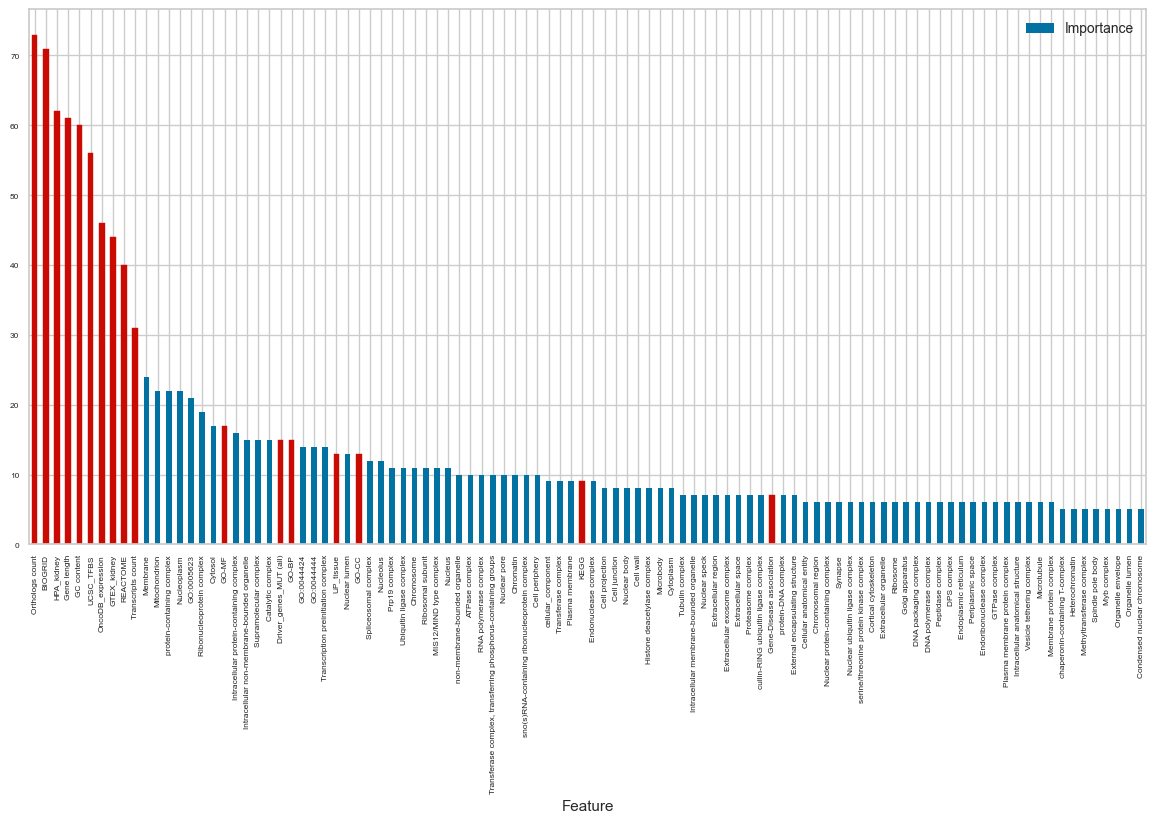

In [47]:
import matplotlib.pyplot as plt
plt.tight_layout()
ax = pd.DataFrame({'Feature': get_config('X_train').columns, 'Importance' : 
                   tuned_lgbm.feature_importances_}).sort_values('Importance', ascending=False).head(100).plot.bar(x='Feature', fontsize=6, y='Importance')
fig = ax.get_figure()
fig.tight_layout()
bioattrs = pd.read_csv(os.path.join(path, 'Kidney_BIO.csv'), index_col=0).columns
for tick, feat in zip(ax.get_children(),ax.get_xticklabels()):
    if feat.get_text() in bioattrs:
        tick.set_color('r')
fig.set_size_inches(12, 12)
#fig.savefig('lgbm_feature_importance.png', dpi=300)

In [51]:
tuned_lgbm.feature_importances_

array([61, 31, 60, ...,  0,  0,  0], dtype=int32)

In [74]:
# this is how you can recreate the table
import pandas as pd
df_importance = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(tuned_lgbm.feature_importances_)}).sort_values(by='Value', ascending=False)
print(len(df_importance[df_importance['Value'] >= 5]))
cccfs_reduced = df_importance[(df_importance['Value'] >= 5) & (df_importance['Feature'].isin(bioattrs) == False)]['Feature']
#plot_model(estimator = tuned_lgbm, plot = 'feature')
cccfs_reduced.to_csv('CCcfs_reduced.csv', index=False)

121


In [84]:
tissue = 'Human'
cccfs = pd.read_csv(os.path.join(path, f"{tissue}_CCcfs.csv"), index_col=0)
cccfs[cccfs_reduced.values].to_csv(os.path.join(path, f"{tissue}_CCcfs_reduce_min5imp.csv"), index=True)